# Node and Edge Embeddings - Using GNN

In [1]:
import pickle
import torch
import networkx as nx
import torch.nn as nn
import matplotlib.pyplot as plt
from functions import AMLDataPreprocessing
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing

![Screenshot 2024-05-23 at 21.28.02.png](<attachment:Screenshot 2024-05-23 at 21.28.02.png>)
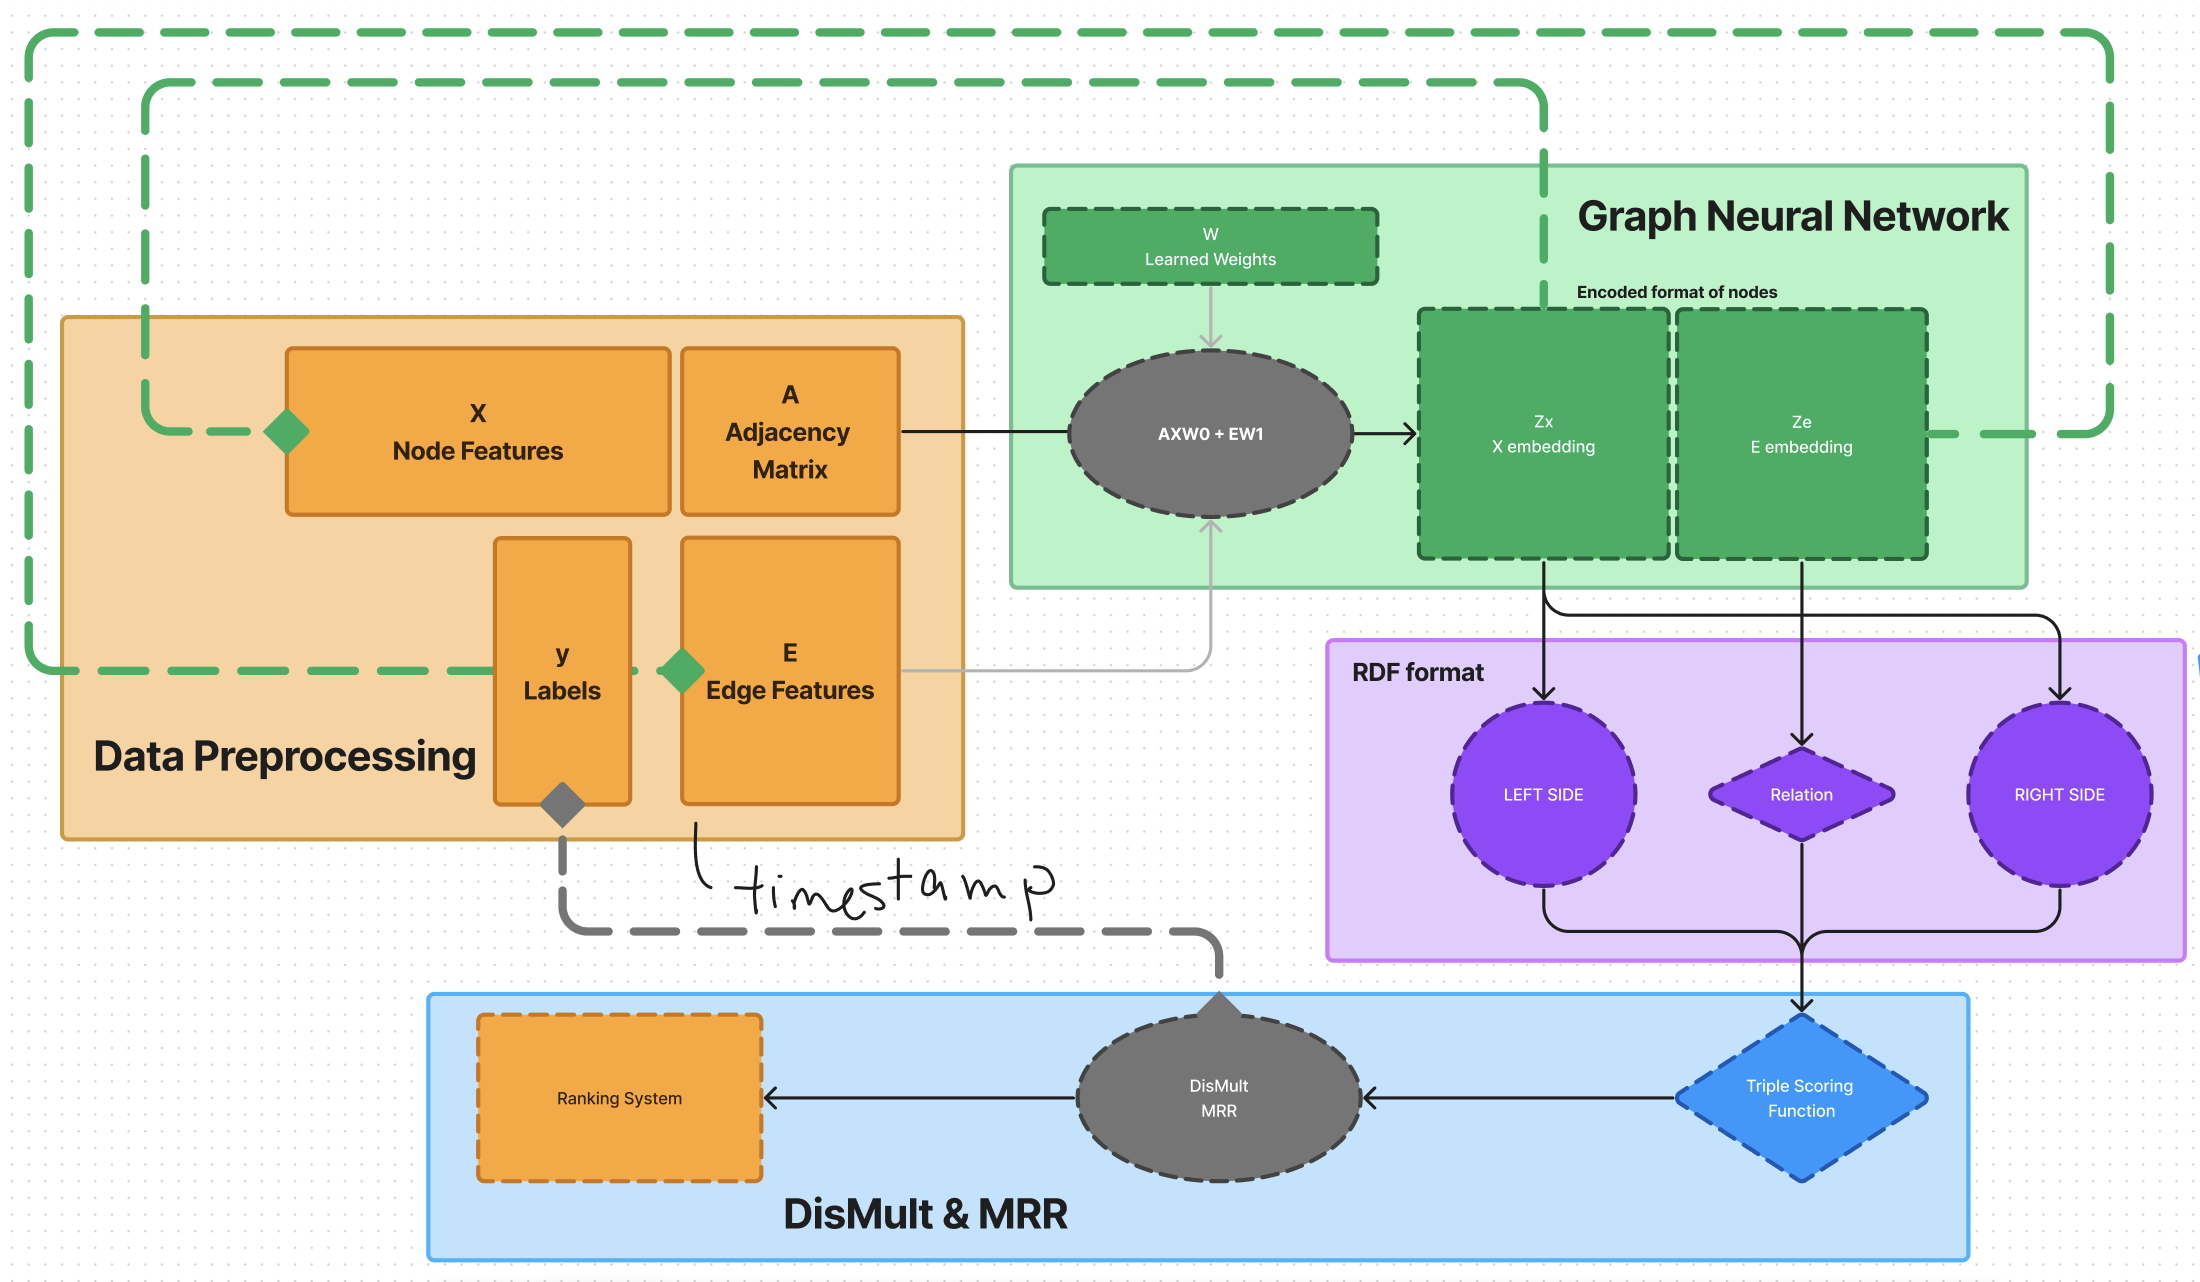

# LOADING GRAPH from Jupyter Notebook 
\(only use if not using Class Preprocessor)

Data Head - <bound method NDFrame.head of              Timestamp  From Bank    Account  To Bank  Account.1  \
0     2022/09/01 00:12      47640  811D69990    47640  811D69990   
1     2022/09/14 12:37      19329  808B1C350     1412  809F49D20   
2     2022/09/03 11:29      17769  8128ED040   223240  8128E8980   
3     2022/09/09 18:44      11899  80532AFB0    29620  80AE51B90   
4     2022/09/04 04:40      27444  80B3BFFD0    11405  80B3D2700   
...                ...        ...        ...      ...        ...   
9995  2022/09/08 09:49      31149  80EB13650    15447  80E0555C0   
9996  2022/09/09 19:44       1362  8001E3BE0     1467  8003F4070   
9997  2022/09/03 00:07     146167  812A57E10    23885  80224DF50   
9998  2022/09/11 17:22       1292  800DF7070        1  8019C00E0   
9999  2022/09/05 09:05         12  800499810    21611  8016625C0   

      Amount Received Receiving Currency  Amount Paid   Payment Currency  \
0               12.57          US Dollar        12.57          US

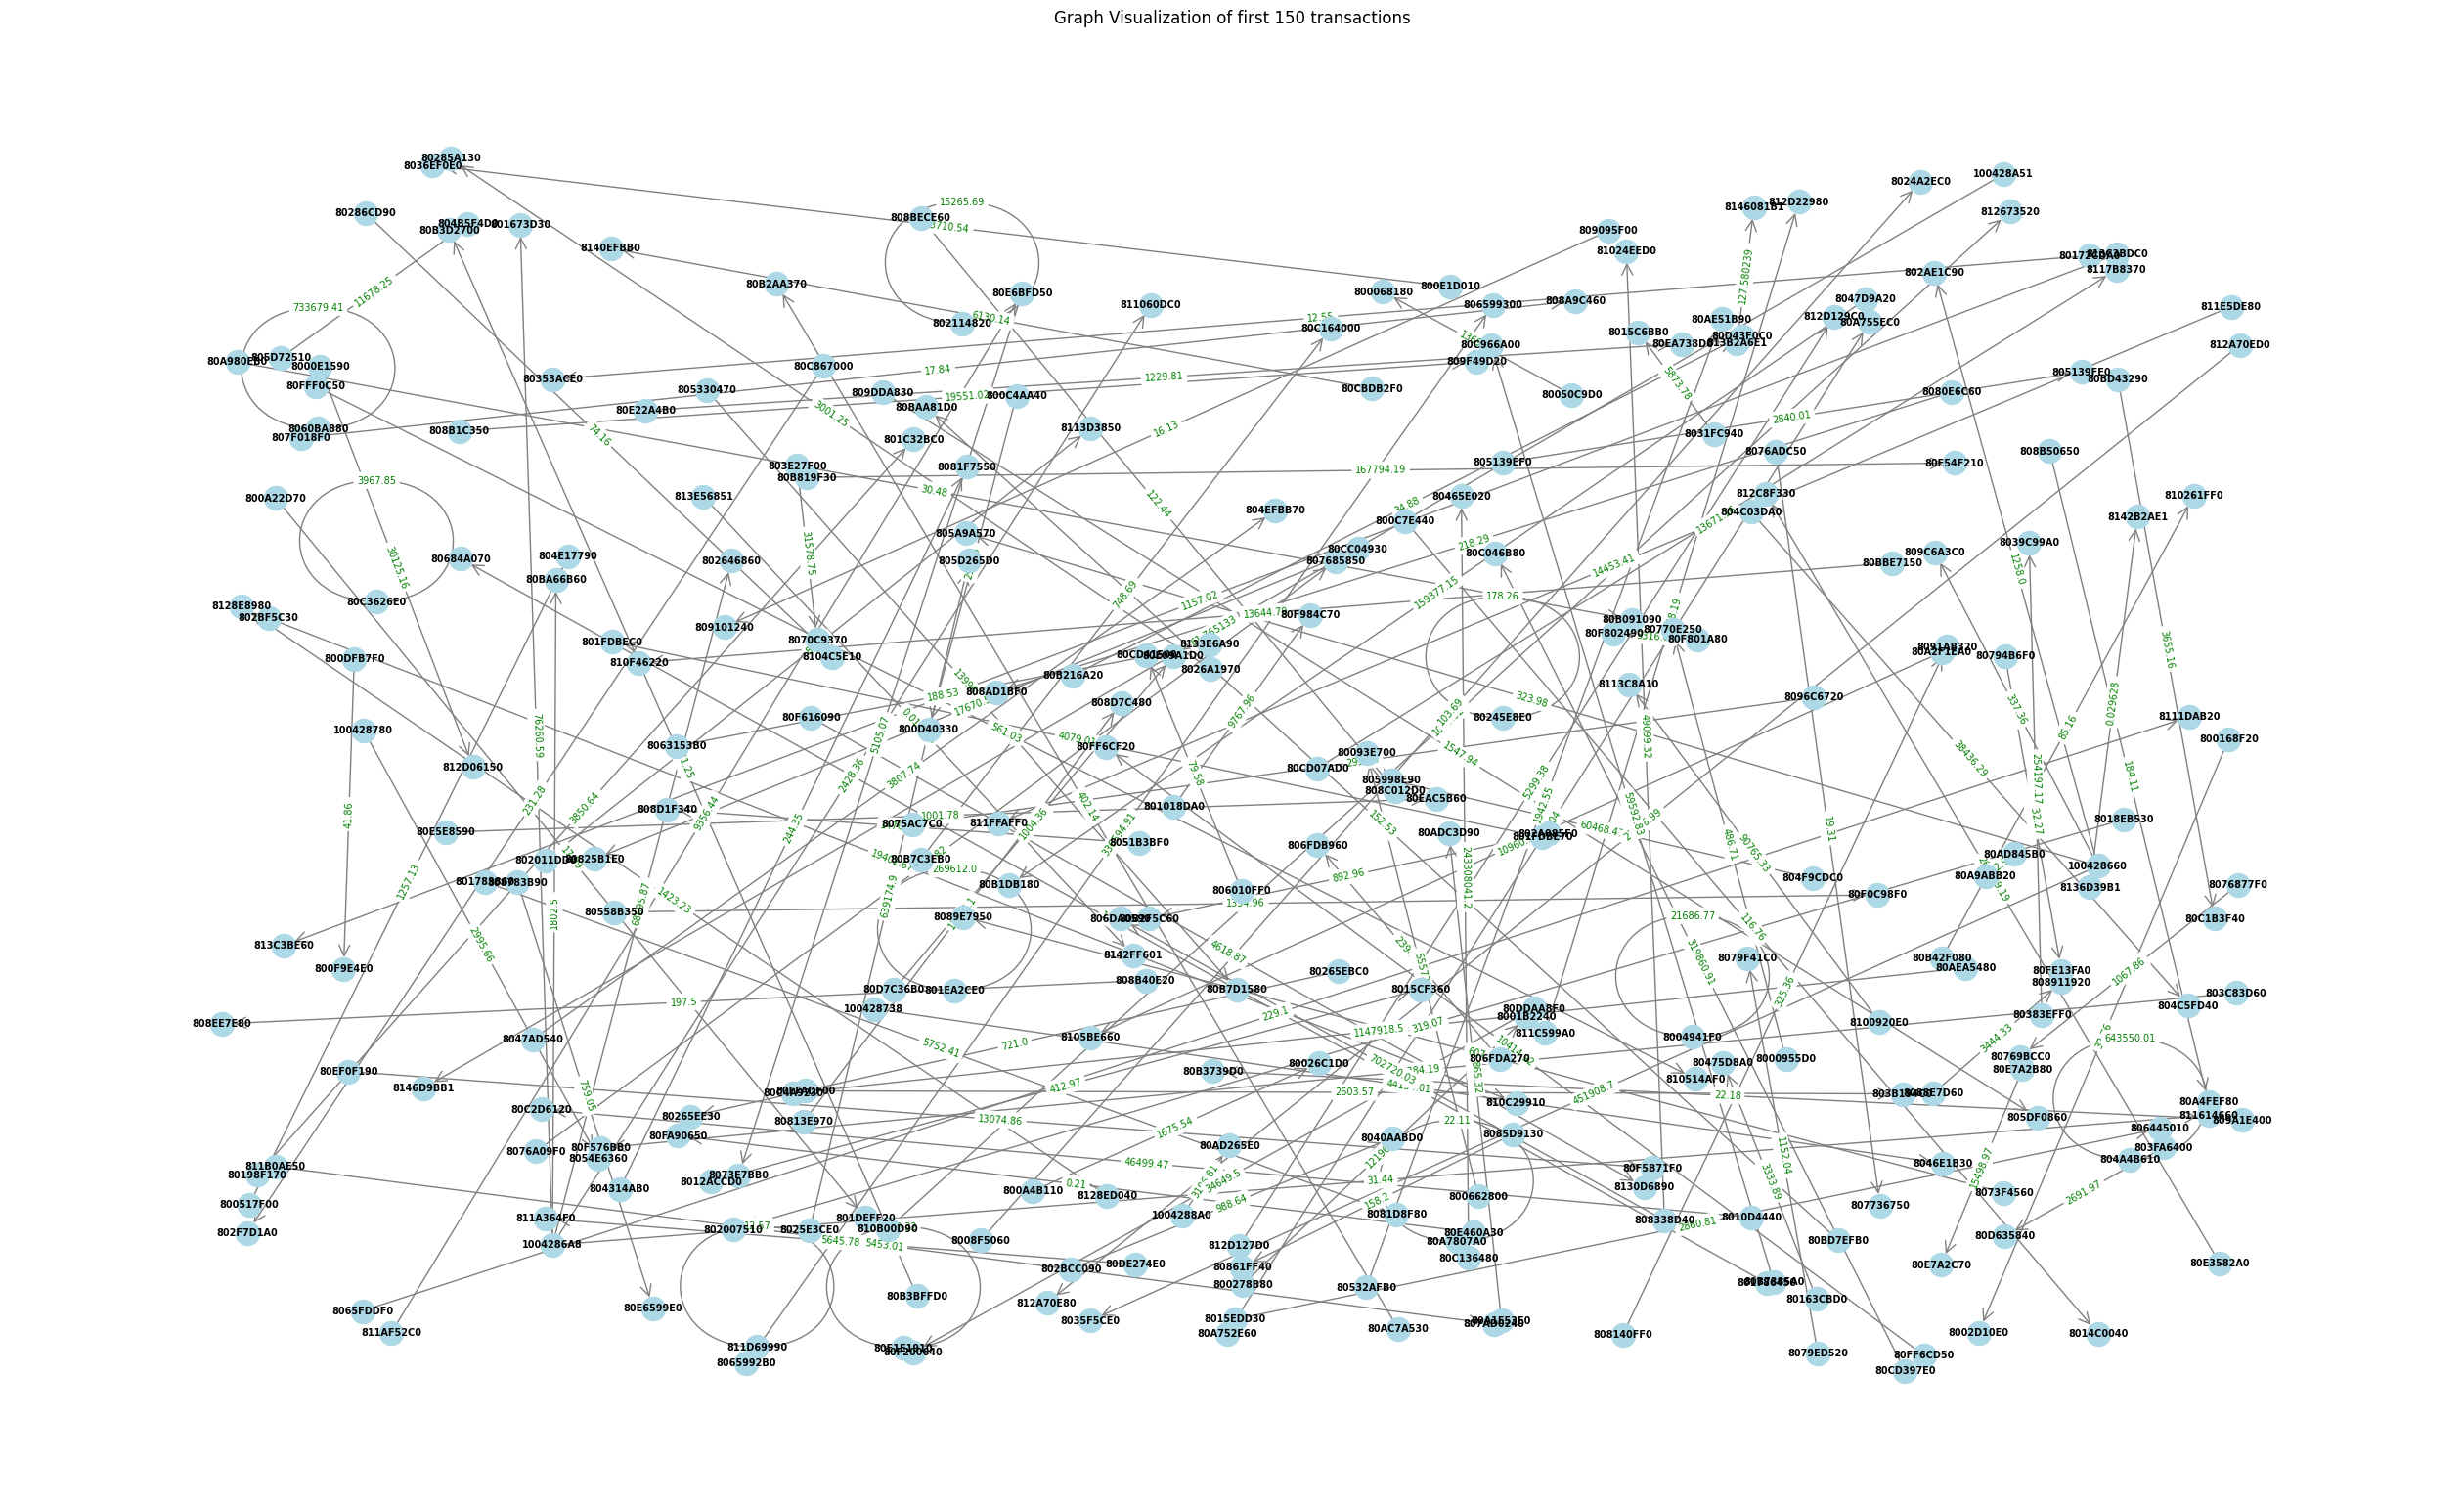

In [ ]:
filename = '/Users/owhy/Documents/Datasets/HI-Small_Trans_balanced.csv'
# Create an instance of the AMLDataPreprocessing class
data_preprocessor = AMLDataPreprocessing(filename)
# Process the data
input_data, graph_full, x, y, labels, links, edges_amount, node_features, edges_features = data_preprocessor.process_data()
# Visualize
visual = data_preprocessor.visualize_graph(links, edges_amount)

adjacency_matrix = torch.from_numpy(nx.adjacency_matrix(graph_full).todense()).to(torch.float)

# PROCESS DATA directly

## Save the data

In [ ]:
with open("graph.pickle", "wb") as f:
    pickle.dump({
        'edges_features': edges_features,
        'links': links,
        'labels': labels,
        'graph_full': graph_full,
        'adjacency_matrix': adjacency_matrix,
        'visual': visual,
        'node_features': node_features,
        'x': x,
        'y': y,
        'labels': labels,
        'input_data': input_data
    }, f)


In [ ]:
input_data.edge_attr.size()

torch.Size([10000, 40])

In [ ]:
labels.size()

torch.Size([10000])

In [ ]:
input_data.x.size()

torch.Size([15899, 44])

In [ ]:
node_features.size()

torch.Size([15899, 44])

In [ ]:
adjacency_matrix.size()

torch.Size([15899, 15899])

# GRAPH NEURAL NETWORKS

In [ ]:
class GNNLayer(MessagePassing):
    def __init__(self, node_features, edge_features, hidden_channels):
        super(GNNLayer, self).__init__(aggr='add')
        self.node_features = node_features
        self.edge_features = edge_features
        self.hidden_channels = hidden_channels
        
        # Learnable parameters
        self.weight_node = nn.Parameter(torch.Tensor(node_features, hidden_channels))
        self.weight_edge = nn.Parameter(torch.Tensor(edge_features, hidden_channels))
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight_node)
        nn.init.xavier_uniform_(self.weight_edge)
        
    def forward(self, x, edge_index, edge_attr):
        # AXW0 + EW1
        global adjacency_matrix
        self.adjacency_matrix = adjacency_matrix

        # print(x.size())
        # print(self.adjacency_matrix.size())
        # print(self.weight_node.size())
        
        axw = torch.matmul(self.adjacency_matrix, x) @ self.weight_node
        ew = torch.matmul(edge_attr, self.weight_edge)

        return axw, ew

    def update(self, aggr_out):
        return aggr_out

In [ ]:
class GNNModel(nn.Module):
    def __init__(self, node_features, edge_features, hidden_channels, out_channels):
        super(GNNModel, self).__init__()
        self.conv1 = GNNLayer(node_features, edge_features, hidden_channels)

        # self.threshold = nn.Parameter(torch.tensor([0.5]))  # Trainable threshold parameter
    
    def forward(self, x, edge_index, edge_attr):
        axw1, ew1 = self.conv1(x, edge_index, edge_attr)

        head_indices, tail_indices = self.mapping(ew1, edge_index)
        scores = self.dismult(axw1, ew1, head_indices, tail_indices)
        
        return axw1, ew1, scores # returning x and e embeddings

    def update_edge_attr(self, edge_attr, new_channels):
        num_edge_features = edge_attr.size(1)
        if new_channels > num_edge_features:
            updated_edge_attr = torch.cat((edge_attr, torch.zeros((edge_attr.size(0), new_channels - num_edge_features), device=edge_attr.device)), dim=1)
        else:
            updated_edge_attr = edge_attr[:, :new_channels]
        return updated_edge_attr
    
    def dismult(self, axw, ew, head_indices, tail_indices):
        scores = []
        heads = []
        tails = []
        relations = []
        for i in range(ew.size()[0]): # going through all triples
            head = axw[head_indices[i]]
            tail = axw[tail_indices[i]]
            relation = ew[i]
            heads.append(head)
            tails.append(tail)
            relations.append(relation)
            raw_score = torch.sum(head * relation * tail, dim=-1)
            normalized_score = torch.sigmoid(raw_score)  # Apply sigmoid activation
            scores.append(raw_score) # calc scores
        scores = torch.stack(scores)
        return scores
    
    def mapping(self, ew, edge_index):
        head_indices = []
        tail_indices = []
        for c in range(ew.size()[0]): # getting all indices
            head_index = edge_index[0][c]
            tail_index = edge_index[1][c]
            head_indices.append(head_index)
            tail_indices.append(tail_index)
        
        return head_indices, tail_indices

In [ ]:
learning_rate = 0.001
hidden_channels = 25
out_channels = 15

model = GNNModel(node_features=input_data.x.size(1), edge_features=input_data.edge_attr.size(1), hidden_channels=hidden_channels, out_channels=out_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()  # Binary classification loss

def train(data):
    model.train()
    optimizer.zero_grad()
    x_embedding, e_embedding, scores = model(data.x, data.edge_index, data.edge_attr)

    loss = criterion(scores, labels)
    loss.backward()
    optimizer.step()
    
    return loss.item(), x_embedding, e_embedding, scores

# Continue training loop from provided script
epochs = 100
losses = []

all_x_embeddings = []
all_e_embeddings = []

for epoch in range(epochs):
    loss, x_embedding, e_embedding, scores = train(input_data)
    losses.append(loss)
    all_x_embeddings.append(x_embedding.detach().cpu().numpy())
    all_e_embeddings.append(e_embedding.detach().cpu().numpy())
    print(f"This is Fraudulent - {scores[8000]}")
    print(f"This is Not fraudulent - {scores[2000]}")
    print(f'Epoch {epoch}, Total Loss: {loss}\n')

This is Fraudulent - 0.5371516942977905
This is Not fraudulent - -0.2144586443901062
Epoch 0, Total Loss: 44.72504806518555

This is Fraudulent - 0.46945977210998535
This is Not fraudulent - -0.2340678870677948
Epoch 1, Total Loss: 38.570125579833984

This is Fraudulent - 0.40566399693489075
This is Not fraudulent - -0.24937796592712402
Epoch 2, Total Loss: 33.29640197753906

This is Fraudulent - 0.3463076055049896
This is Not fraudulent - -0.2629672586917877
Epoch 3, Total Loss: 29.043581008911133

This is Fraudulent - 0.2909785211086273
This is Not fraudulent - -0.2799198031425476
Epoch 4, Total Loss: 25.233890533447266

This is Fraudulent - 0.24002504348754883
This is Not fraudulent - -0.2960129976272583
Epoch 5, Total Loss: 21.83868980407715

This is Fraudulent - 0.19327962398529053
This is Not fraudulent - -0.3112819790840149
Epoch 6, Total Loss: 18.913419723510742

This is Fraudulent - 0.15338242053985596
This is Not fraudulent - -0.32320067286491394
Epoch 7, Total Loss: 16.55721

In [ ]:
scores[6500]

tensor(2.9919, grad_fn=<SelectBackward0>)

In [ ]:
labels[6500]

tensor(1.)

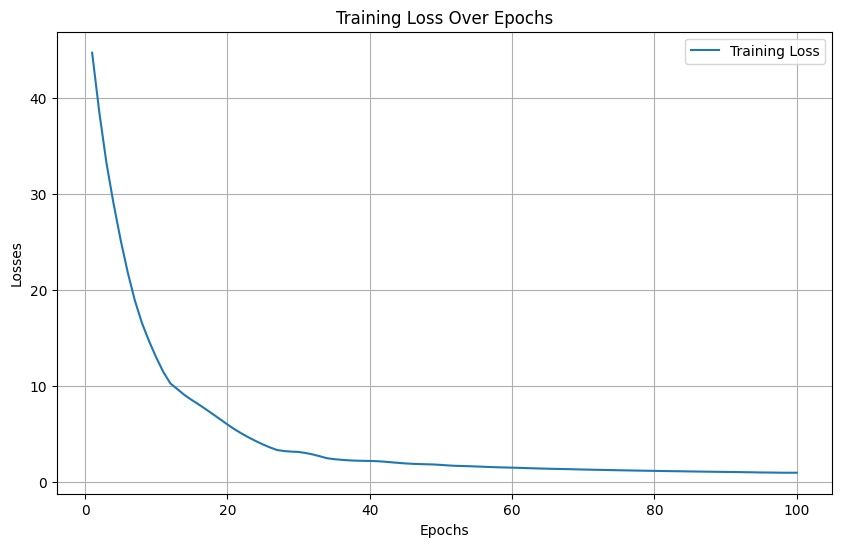

In [ ]:
# plot losses
epoch_numbers = list(range(1, epochs + 1))

plt.figure(figsize=(10,6))
plt.plot(epoch_numbers, losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
with torch.no_grad():
    # scores = model(heads, relations, tails).squeeze()
    sorted_indices = torch.argsort(scores, descending=True)
    true_indices = sorted_indices[:torch.sum(labels).int()]  # Select top predictions based on number of positive labels
    predictions = torch.zeros(len(labels))
    predictions[true_indices] = 1
    mrr = 0
    for i, idx in enumerate(true_indices):
        if labels[idx].item() == 1:
            mrr = 1 / (i + 1)  # MRR calculation
            break
    print("Mean Reciprocal Rank (MRR):", mrr)

Mean Reciprocal Rank (MRR): 0.5


In [ ]:
predictions

tensor([0., 0., 0.,  ..., 1., 1., 0.])

In [ ]:
labels

tensor([0., 1., 0.,  ..., 0., 1., 0.])

In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

def evaluate_model(predictions, true_values):
    # Convert tensors to numpy arrays
    predictions = predictions.cpu().numpy()
    true_values = true_values.cpu().numpy()
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(true_values, predictions)
    precision = precision_score(true_values, predictions)
    recall = recall_score(true_values, predictions)
    f1 = f1_score(true_values, predictions)
    cm = confusion_matrix(true_values, predictions)
    classification_rep = classification_report(true_values, predictions)
    
    # ROC Curve and AUC if applicable
    try:
        fpr, tpr, thresholds = roc_curve(true_values, predictions)
        roc_auc = auc(fpr, tpr)
    except ValueError:
        fpr, tpr, roc_auc = None, None, None
    
    metrics_dict = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Confusion Matrix": cm,
        "Classification Report": classification_rep,
        "ROC Curve": (fpr, tpr, roc_auc)
    }
    
    return metrics_dict


In [ ]:
metrics_dict = evaluate_model(predictions, labels)

# Print Evaluation Metrics
print("Evaluation Metrics:")
print("-------------------\n")
for metric_name, metric_value in metrics_dict.items():
    if metric_name == "Confusion Matrix":
        print("Confusion Matrix:")
        print(metric_value)
    elif metric_name == "Classification Report":
        print("Classification Report:")
        print(metric_value)
    elif metric_name == "ROC Curve":
        fpr, tpr, roc_auc = metric_value
        print("ROC Curve:")
        print("- False Positive Rate:", fpr)
        print("- True Positive Rate:", tpr)
        print("- AUC:", roc_auc)
    else:
        print(f"{metric_name}: {metric_value}")
    print()

Evaluation Metrics:
-------------------

Accuracy: 0.5856

Precision: 0.30933333333333335

Recall: 0.30933333333333335

F1 Score: 0.30933333333333335

Confusion Matrix:
[[4928 2072]
 [2072  928]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.70      0.70      7000
         1.0       0.31      0.31      0.31      3000

    accuracy                           0.59     10000
   macro avg       0.51      0.51      0.51     10000
weighted avg       0.59      0.59      0.59     10000


ROC Curve:
- False Positive Rate: [0.    0.296 1.   ]
- True Positive Rate: [0.         0.30933333 1.        ]
- AUC: 0.5066666666666667



# Save in RDF format

In [ ]:
import gzip
import torch

def save_embeddings_as_triples(edge_index, node_embeddings, edge_embeddings, file_path):
    with gzip.open(file_path, 'wt') as f:
        for i in range(edge_index.size(1)):
            head_index = edge_index[0, i].item()
            tail_index = edge_index[1, i].item()
            head_uri = f"http://example.org/node/{head_index}"
            tail_uri = f"http://example.org/node/{tail_index}"
            relation_uri = f"http://example.org/relation/{i}"

            # Write connectedTo triple
            f.write(f'<{head_uri}> <http://example.org/ontology#connectedTo> <{tail_uri}>\n')
            
            # Write head node embedding triple
            head_embedding = node_embeddings[head_index].numpy()
            head_str = ' '.join(map(str, head_embedding))
            f.write(f'<{head_uri}> <http://example.org/ontology#hasEmbedding> "{head_str}"\n')
            
            # Write tail node embedding triple
            tail_embedding = node_embeddings[tail_index].numpy()
            tail_str = ' '.join(map(str, tail_embedding))
            f.write(f'<{tail_uri}> <http://example.org/ontology#hasEmbedding> "{tail_str}"\n')
            
            # Write edge embedding triple
            relation_embedding = edge_embeddings[i].numpy()
            relation_str = ' '.join(map(str, relation_embedding))
            f.write(f'<{relation_uri}> <http://example.org/ontology#hasEmbedding> "{relation_str}"\n')

# Example usage after training
x_embeddings = torch.tensor(all_x_embeddings[-1])  # Use the last epoch's embeddings
e_embeddings = torch.tensor(all_e_embeddings[-1])  # Use the last epoch's embeddings

save_embeddings_as_triples(input_data.edge_index, x_embeddings, e_embeddings, 'embeddings.nt.gz')


In [ ]:
import gzip

def print_rdf_triples(file_path):
    # counter = 0
    with gzip.open(file_path, 'rt') as f:
        counter = 0
        for line in f:
            print(line.strip())
            counter += 1
    print(counter)

# Replace 'embeddings.nt.gz' with the actual file path
print_rdf_triples("embeddings.nt.gz") # CONNECTED TO --> HAS EMBEDDING
# print(4999*4)

In [ ]:
def evaluate_reconstruction(x_embeddings, e_embeddings, model, input_data):
    model.eval()
    reconstructed_x = model.decoder_x(torch.tensor(x_embeddings).to(input_data.x.device))
    reconstructed_e = model.decoder_e(torch.tensor(e_embeddings).to(input_data.edge_attr.device))
    
    mse_loss = nn.MSELoss()
    loss_x = mse_loss(reconstructed_x, input_data.x)
    loss_e = mse_loss(reconstructed_e, input_data.edge_attr)
    
    return loss_x.item(), loss_e.item()

loss_x, loss_e = evaluate_reconstruction(all_x_embeddings[-1], all_e_embeddings[-1], model, input_data)
print(f'Reconstruction Loss for Node Features: {loss_x}')
print(f'Reconstruction Loss for Edge Features: {loss_e}')

In [ ]:
with open("embeddings.pickle", "wb") as f:
    pickle.dump({
        'x_embeddings': x_embeddings,
        'e_embeddings': e_embeddings
    }, f)